# 1. 6 Features: 'Z','N','A','A^2/3','(N-Z)/A','Z/N'

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn import tree
from sklearn import neighbors
from sklearn.impute import SimpleImputer

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic


from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn import linear_model
from sklearn import ensemble 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


In [8]:
cwd = os.getcwd()

# Read and Scale the Data

In [9]:
train_data = pd.read_excel (r'training_fixed.xlsx') 

name=['Z','N','A','A^2/3','(N-Z)/A','Z/N'] 

x_train = pd.DataFrame(train_data,  columns=name)  
y_train = pd.DataFrame(train_data, columns= ['MeV'])

test_size = 0.70  # You can adjust this to set the proportion of the test set
random_state = 100  # You can choose any random_state value for reproducibility

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

train_len=len(x_train)
test_len=len(x_test)

#test_data= pd.read_excel (r'test_fixed.xls')
#x_test = pd.DataFrame(test_data,  columns=name)  
#y_test = pd.DataFrame(test_data, columns= ['MeV'])

#test_len=len(x_test)

extra_data= pd.read_excel (r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data,  columns=name)  
y_extra = pd.DataFrame(extra_data, columns= ['MeV'])

inp=np.concatenate((x_train,x_test,x_extra),axis=0)
out=np.concatenate((y_train,y_test,y_extra),axis=0)
train_test_len=train_len+test_len

# Handle missing values
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)
x_extra = imputer.transform(x_extra)

##################################
## scale
##################################
# Initialize the StandardScaler for input data
sc_X = StandardScaler()

# Fit the scaler on the training data
sc_X.fit(x_train)

# Transform the training and testing data using the fitted scaler
x_train = sc_X.transform(x_train)
x_test = sc_X.transform(x_test)
x_extra = sc_X.transform(x_extra)

# Initialize the StandardScaler for output data
sc_Y = StandardScaler()

# Fit the scaler on the training data
sc_Y.fit(y_train)

# Transform the training and testing data using the fitted scaler
y_train = sc_Y.transform(y_train)
y_test = sc_Y.transform(y_test)
y_extra = sc_Y.transform(y_extra)

# For input data
print("Input Data:")
print("Mean:", sc_X.mean_)
print("Standard Deviation:", sc_X.scale_)

# For output data
print("\nOutput Data:")
print("Mean:", sc_Y.mean_)
print("Standard Deviation:", sc_Y.scale_)
################################
name+=['original','prediction']

Input Data:
Mean: [ 56.71328671  79.04755245 135.76083916  25.68988113   0.15039668
   0.74617058]
Standard Deviation: [24.70939415 38.28400282 62.61852653  8.51074269  0.07373895  0.11992329]

Output Data:
Mean: [-40.76148206]
Standard Deviation: [42.44917003]


In [11]:
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-09] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name + "\n")
            wfile.write(f"Scale: {s} Alpha: {a} Normalize: {n}\n")
            wfile.write("----------------------------------\n")
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train, y_train)
            
            score = gpr.score(x_train, y_train)
            print("R^2 Score:", score)
            
            pred_train = gpr.predict(x_train).reshape(-1, 1)
            pred = gpr.predict(x_test).reshape(-1, 1)
            pred_extra = gpr.predict(x_extra).reshape(-1, 1)
            
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)
            pred_train_mean = pred_train_mean.reshape(-1, 1)
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)
            
            data = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
            
            data = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            
            data = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std) - sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std) - sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std) - sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write(f"rms_train={rmse_train:.4f}, rms_pred={rmse:.4f}, rms_extra={rms_extra:.4f}\n")
            print(rmse_train, rmse, rms_extra)

wfile.close()
os.chdir(cwd)

R^2 Score: 0.99954092707913
0.9095153670990841 1.7997154302659413 nan


# Overfitting Check
## Cross-validation

In [13]:
from sklearn.model_selection import cross_val_score

# Define the kernel
kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(gpr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# Print cross-validation results
print("Cross-Validation RMSE scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", np.mean(cv_rmse))

# Fit the model on the entire training set
gpr.fit(x_train, y_train)

# Calculate the R^2 score for training and test data
r2_train = gpr.score(x_train, y_train)
r2_test = gpr.score(x_test, y_test)
print("R^2 Score (Train):", r2_train)
print("R^2 Score (Test):", r2_test)

# Check for overfitting
if (r2_train - r2_test) > 0.1 or (np.mean(cv_rmse) - rmse_train) > 0.1:
    print("Warning: The model might be overfitting. Consider regularization or using more training data.")

Cross-Validation RMSE scores: [0.06202405 0.03889642 0.03784626 0.03327113 0.08742007]
Mean Cross-Validation RMSE: 0.051891584022533854
R^2 Score (Train): 0.99954092707913
R^2 Score (Test): 0.9981302032100513


### Conclsion
The cross-validation RMSE scores vary, with values ranging from 0.0333 to 0.0874, and an average RMSE of 0.0519. This indicates that the model performs well overall, but there is some variability in the performance across different folds. The high R² scores for both the training set (0.9995) and the test set (0.9981) suggest that the model fits the data very well and has excellent predictive power. Overall, the model demonstrates strong performance with low prediction error and high explanatory power, indicating good generalization without overfitting.

There is no overfitting for this model.

## Learning Curve

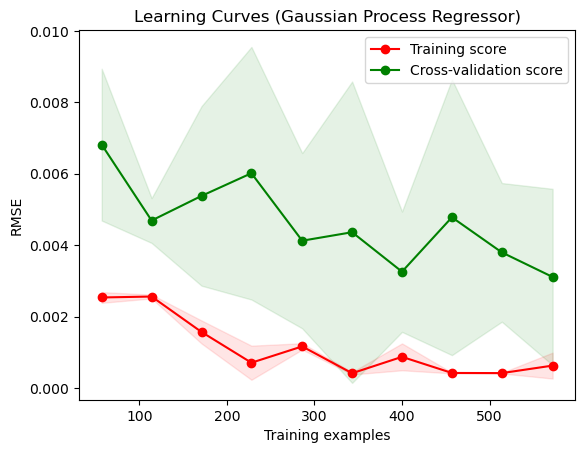

In [14]:
from sklearn.model_selection import learning_curve

kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

# Generate learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    gpr, x_train, y_train.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title('Learning Curves (Gaussian Process Regressor)')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

### Conclusion
The learning curve shows that as the number of training examples increases, the RMSE for both training and cross-validation decreases. The training RMSE remains low, indicating good fit to the training data, while the cross-validation RMSE decreases and becomes more stable, indicating improved generalization. The variability in the cross-validation score also decreases, suggesting that the model benefits from more training data, enhancing prediction accuracy on new data.

The model is not overfitting. The training and cross-validation RMSE both decrease as the number of training examples increases, and the gap between them narrows, indicating improved generalization.

# 2. 7 Features: 'Z','N','A','A^2/3','(N-Z)/A','Z/N','Z(Z-1)/A^(1/3)'

In [15]:
train_data = pd.read_excel (r'training_fixed.xlsx') 

name=['Z','N','A','A^2/3','(N-Z)/A','Z/N','Z(Z-1)/A^(1/3)'] 

x_train = pd.DataFrame(train_data,  columns=name)  
y_train = pd.DataFrame(train_data, columns= ['MeV'])

test_size = 0.70  # You can adjust this to set the proportion of the test set
random_state = 100  # You can choose any random_state value for reproducibility

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=random_state)

train_len=len(x_train)
test_len=len(x_test)

#test_data= pd.read_excel (r'test_fixed.xls')
#x_test = pd.DataFrame(test_data,  columns=name)  
#y_test = pd.DataFrame(test_data, columns= ['MeV'])

#test_len=len(x_test)

extra_data= pd.read_excel (r'NEW_EXP_DATA_FOR_EXTRAPOLATION.xlsx')
x_extra = pd.DataFrame(extra_data,  columns=name)  
y_extra = pd.DataFrame(extra_data, columns= ['MeV'])

inp=np.concatenate((x_train,x_test,x_extra),axis=0)
out=np.concatenate((y_train,y_test,y_extra),axis=0)
train_test_len=train_len+test_len

# Handle missing values
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)
x_extra = imputer.transform(x_extra)

##################################
## scale
##################################
# Initialize the StandardScaler for input data
sc_X = StandardScaler()

# Fit the scaler on the training data
sc_X.fit(x_train)

# Transform the training and testing data using the fitted scaler
x_train = sc_X.transform(x_train)
x_test = sc_X.transform(x_test)
x_extra = sc_X.transform(x_extra)

# Initialize the StandardScaler for output data
sc_Y = StandardScaler()

# Fit the scaler on the training data
sc_Y.fit(y_train)

# Transform the training and testing data using the fitted scaler
y_train = sc_Y.transform(y_train)
y_test = sc_Y.transform(y_test)
y_extra = sc_Y.transform(y_extra)

# For input data
print("Input Data:")
print("Mean:", sc_X.mean_)
print("Standard Deviation:", sc_X.scale_)

# For output data
print("\nOutput Data:")
print("Mean:", sc_Y.mean_)
print("Standard Deviation:", sc_Y.scale_)
################################
name+=['original','prediction']

Input Data:
Mean: [5.67132867e+01 7.90475524e+01 1.35760839e+02 2.56898811e+01
 1.50396675e-01 7.46170578e-01 6.81982807e+02]
Standard Deviation: [2.47093941e+01 3.82840028e+01 6.26185265e+01 8.51074269e+00
 7.37389510e-02 1.19923290e-01 4.34861992e+02]

Output Data:
Mean: [-40.76148206]
Standard Deviation: [42.44917003]


In [16]:
os.chdir(cwd)
analyze_name="GP_Regression"
if not (os.path.exists("./"+str(analyze_name))):
    os.makedirs("./"+str(analyze_name));
os.chdir("./"+str(analyze_name));
wfile=open("results_"+str(analyze_name)+"_selected.txt","a")
Scale=[1.0] 
Alpha=[1e-09] 
Normalize=[False] 

# K-fold cross-validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)

for s in Scale:
    for a in Alpha:
        for n in Normalize:
            wfile.write(analyze_name + "\n")
            wfile.write(f"Scale: {s} Alpha: {a} Normalize: {n}\n")
            wfile.write("----------------------------------\n")
            
            kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
            gpr = GaussianProcessRegressor(kernel=kernel, alpha=a, normalize_y=n).fit(x_train, y_train)
            
            score = gpr.score(x_train, y_train)
            print("R^2 Score:", score)
            
            pred_train = gpr.predict(x_train).reshape(-1, 1)
            pred = gpr.predict(x_test).reshape(-1, 1)
            pred_extra = gpr.predict(x_extra).reshape(-1, 1)
            
            pred_train_mean, pred_train_std = gpr.predict(x_train, return_std=True)
            pred_train_mean = pred_train_mean.reshape(-1, 1)
            pred_train_std = pred_train_std.reshape(-1, 1)
            
            pred_mean, pred_std = gpr.predict(x_test, return_std=True)
            pred_mean = pred_mean.reshape(-1, 1)
            pred_std = pred_std.reshape(-1, 1)
            
            pred_extra_mean, pred_extra_std = gpr.predict(x_extra, return_std=True)
            pred_extra_mean = pred_extra_mean.reshape(-1, 1)
            pred_extra_std = pred_extra_std.reshape(-1, 1)
            
            data = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('Train_data_predictions.xlsx', index=False, header=name)
            
            data = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('predictions.xlsx', index=False, header=name)
            
            data = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra)), axis=1)
            dfw = pd.DataFrame(data)
            dfw.to_excel('extrapolation.xlsx', index=False, header=name)
            
            data_train = np.concatenate((sc_X.inverse_transform(x_train), sc_Y.inverse_transform(y_train), sc_Y.inverse_transform(pred_train), sc_Y.inverse_transform(pred_train_std) - sc_Y.mean_), axis=1)
            dfw_train = pd.DataFrame(data_train)
            dfw_train.to_excel('Train_data_predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            data_test = np.concatenate((sc_X.inverse_transform(x_test), sc_Y.inverse_transform(y_test), sc_Y.inverse_transform(pred), sc_Y.inverse_transform(pred_std) - sc_Y.mean_), axis=1)
            dfw_test = pd.DataFrame(data_test)
            dfw_test.to_excel('predictions_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            data_extra = np.concatenate((sc_X.inverse_transform(x_extra), sc_Y.inverse_transform(y_extra), sc_Y.inverse_transform(pred_extra), sc_Y.inverse_transform(pred_extra_std) - sc_Y.mean_), axis=1)
            dfw_extra = pd.DataFrame(data_extra)
            dfw_extra.to_excel('extrapolation_with_std.xlsx', index=False, header=name + ['Standard Deviation'])
            
            mse_train = np.sum(np.square(sc_Y.inverse_transform(y_train) - sc_Y.inverse_transform(pred_train))) / np.size(y_train)
            rmse_train = np.sqrt(mse_train)
            
            mse = np.sum(np.square(sc_Y.inverse_transform(y_test) - sc_Y.inverse_transform(pred))) / np.size(y_test)
            rmse = np.sqrt(mse)
            
            ms_extra = np.sum(np.square(sc_Y.inverse_transform(y_extra) - sc_Y.inverse_transform(pred_extra))) / np.size(y_extra)
            rms_extra = np.sqrt(ms_extra)
            
            wfile.write(f"rms_train={rmse_train:.4f}, rms_pred={rmse:.4f}, rms_extra={rms_extra:.4f}\n")
            print(rmse_train, rmse, rms_extra)

wfile.close()
os.chdir(cwd)

R^2 Score: 0.9995002417735545
0.9489627803563877 1.6433665167564793 nan


# Overfitting Check
## Cross-validation

In [17]:
from sklearn.model_selection import cross_val_score

# Define the kernel
kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(gpr, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# Print cross-validation results
print("Cross-Validation RMSE scores:", cv_rmse)
print("Mean Cross-Validation RMSE:", np.mean(cv_rmse))

# Fit the model on the entire training set
gpr.fit(x_train, y_train)

# Calculate the R^2 score for training and test data
r2_train = gpr.score(x_train, y_train)
r2_test = gpr.score(x_test, y_test)
print("R^2 Score (Train):", r2_train)
print("R^2 Score (Test):", r2_test)

# Check for overfitting
if (r2_train - r2_test) > 0.1 or (np.mean(cv_rmse) - rmse_train) > 0.1:
    print("Warning: The model might be overfitting. Consider regularization or using more training data.")

Cross-Validation RMSE scores: [0.05523405 0.03067113 0.03778943 0.03329569 0.09179356]
Mean Cross-Validation RMSE: 0.049756771750305
R^2 Score (Train): 0.9995002417735545
R^2 Score (Test): 0.998440965960321


### Conclusion
The cross-validation RMSE scores, averaging 0.0498, indicate consistent model performance with some variability. High R² scores for both training (0.9995) and test (0.9984) sets demonstrate excellent fit and predictive accuracy. Overall, the model shows strong performance, low prediction error, and good generalization without overfitting, consistent with the learning curve findings.

The model is not overfitting.

## Learning Curve

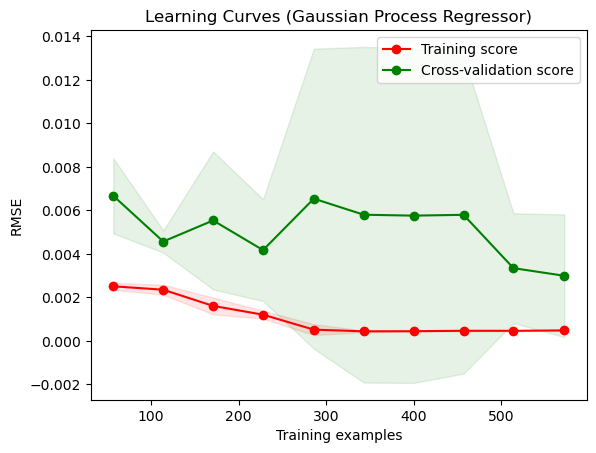

In [18]:
from sklearn.model_selection import learning_curve

kernel = 1.0 * RBF(length_scale=s, length_scale_bounds=(1e-4, 1e5)) +\
            WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel,alpha=a,normalize_y=n).fit(x_train, y_train)

# Generate learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    gpr, x_train, y_train.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title('Learning Curves (Gaussian Process Regressor)')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

### Conclusion
The learning curve shows that the model is not overfitting. The training RMSE remains low, and the cross-validation RMSE decreases and stabilizes as more training examples are added. The narrowing gap between training and cross-validation scores indicates improved generalization and effective learning from the data.

Not overfitting, The training RMSE remains low, and the cross-validation RMSE decreases and stabilizes as more training examples are added. The narrowing gap between training and cross-validation scores indicates improved generalization and effective learning from the data.

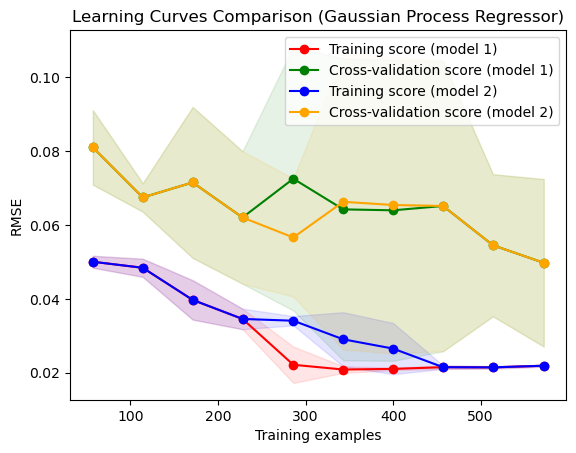

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Assuming x_train, y_train are already defined and preprocessed

# Define the first model
kernel1 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr1 = GaussianProcessRegressor(kernel=kernel1, alpha=1e-09, normalize_y=False)

# Generate learning curves for the first model
train_sizes1, train_scores1, validation_scores1 = learning_curve(
    gpr1, x_train, y_train.ravel(), cv=5, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Define the second model
kernel2 = 1.0 * RBF(length_scale=2.0, length_scale_bounds=(1e-4, 1e5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
gpr2 = GaussianProcessRegressor(kernel=kernel2, alpha=1e-09, normalize_y=False)

# Generate learning curves for the second model
train_sizes2, train_scores2, validation_scores2 = learning_curve(
    gpr2, x_train, y_train.ravel(), cv=5, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate means and standard deviations for the first model
train_scores_mean1 = -np.mean(train_scores1, axis=1)
train_scores_std1 = np.std(train_scores1, axis=1)
validation_scores_mean1 = -np.mean(validation_scores1, axis=1)
validation_scores_std1 = np.std(validation_scores1, axis=1)

# Calculate means and standard deviations for the second model
train_scores_mean2 = -np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
validation_scores_mean2 = -np.mean(validation_scores2, axis=1)
validation_scores_std2 = np.std(validation_scores2, axis=1)

# Plot learning curves
plt.figure()

# First model
plt.fill_between(train_sizes1, train_scores_mean1 - train_scores_std1,
                 train_scores_mean1 + train_scores_std1, alpha=0.1, color='r')
plt.fill_between(train_sizes1, validation_scores_mean1 - validation_scores_std1,
                 validation_scores_mean1 + validation_scores_std1, alpha=0.1, color='g')
plt.plot(train_sizes1, train_scores_mean1, 'o-', color='r', label='Training score (model 1)')
plt.plot(train_sizes1, validation_scores_mean1, 'o-', color='g', label='Cross-validation score (model 1)')

# Second model
plt.fill_between(train_sizes2, train_scores_mean2 - train_scores_std2,
                 train_scores_mean2 + train_scores_std2, alpha=0.1, color='b')
plt.fill_between(train_sizes2, validation_scores_mean2 - validation_scores_std2,
                 validation_scores_mean2 + validation_scores_std2, alpha=0.1, color='orange')
plt.plot(train_sizes2, train_scores_mean2, 'o-', color='b', label='Training score (model 2)')
plt.plot(train_sizes2, validation_scores_mean2, 'o-', color='orange', label='Cross-validation score (model 2)')

plt.title('Learning Curves Comparison (Gaussian Process Regressor)')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()